In [60]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [67]:
# set some default
pd.set_option('display.float_format', str)
sns.set_palette('Spectral')

In [163]:
df = pd.read_pickle('data_Han/Han_df_cleaned')

In [164]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.0,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.721,-122.319,1690,7639
2,180000.0,2,1.0,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.0,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.0,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [165]:
df.view.value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int8   
 8   condition      21597 non-null  int8   
 9   grade          21597 non-null  int32  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int32  
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

# ASSUMPTIONS ON KEY FEATURES

 * location
 * living space, especially a good bathroom
 * House condition
 * distance to downtown/office
 * neighborhood

## list of things to explore

***LOCATION***
 * zipcode - area
 * waterfront/view important
 * neiborhood amenities
 * is height important?/flood
 
***LIVING SPACE*** 
 * bigger house sells more?
 * more bedrooms/bathrooms sells more?
 * more floors sells more?
 * space allocations
 * Floor Area Ratio sells more?
 
***HOUSE CONDITION***
* year built & renovated
* Age & condition

***NEIGHBORHOOD***
* amenities, parks, hospitals, etc...
* safety
 
***INVESTMENT***
 * year built
 * view/waterfront
 * flood zone/latitude
 
 
***OVERALL INTUITION***
 * sqrt_living
 * bedrooms/bathrooms
 * view/waterfront
 * zipcode
 * year_built

# EDA LOCATION

In [5]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [73]:
df_temp = df.zipcode.value_counts()

### which zipcode has highest average price?

In [86]:
col_selector = ['price','zipcode','sqft_living']
df_loc = df[col_selector]
df_loc.head()

,price,zipcode,sqft_living
0,221900.0,98178,1180
1,538000.0,98125,2570
2,180000.0,98028,770
3,604000.0,98136,1960
4,510000.0,98074,1680


In [87]:
df_loc.shape

(21597, 3)

In [88]:
df_avg_price_zipcode = df_loc.groupby('zipcode').mean().sort_values(by='price')
df_avg_price_zipcode.head()

,price,sqft_living
zipcode,,
98002,234284.0351758794,1627.7437185929648
98168,240328.3717472119,1468.6245353159852
98032,251296.24,1738.048
98001,281194.8698060942,1903.7839335180056
98148,284908.5964912281,1610.5263157894738


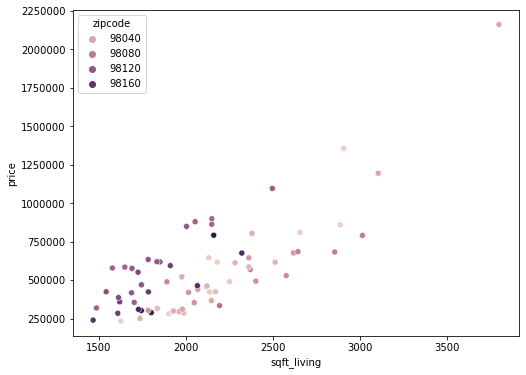

In [54]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(hue=df_avg_price_zipcode.index,
                y='price', x='sqft_living',
               data=df_avg_price_zipcode)
ax.ticklabel_format(style='plain');

# for i in range(df_avg_price_zipcode.shape[0]):
#     plt.text(x = df_avg_price_zipcode.sqft_living[i], y = df_avg_price_zipcode.price[i], s = df_avg_price_zipcode.index[i],fontsize=11);

In [100]:
df_avg_price_zipcode

zipcode
98002    1
98168    1
98032    1
98001    1
98148    1
        ..
98102    3
98112    4
98040    4
98004    5
98039    7
Name: price, Length: 70, dtype: category
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [104]:
pd.cut(df_avg_price_zipcode.price, 4, labels=[1,2,3,4]).value_counts()

1    57
2    11
4     1
3     1
Name: price, dtype: int64

# EDA LIVING SPACE

In [198]:
col_selector = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_basement']
df_ls = df[col_selector]

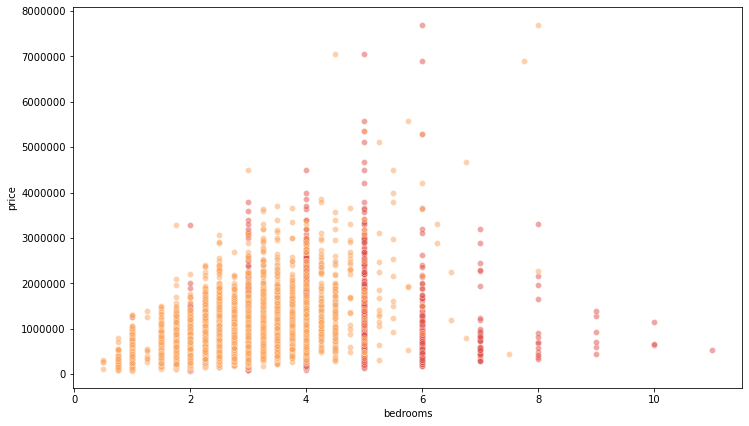

In [215]:
fig,ax = plt.subplots(figsize=(12,7))
sns.scatterplot(x = 'bedrooms', y = 'price', data = df_ls,alpha=0.5)
sns.scatterplot(x = 'bathrooms', y = 'price', data = df_ls,alpha=0.5)
ax.ticklabel_format(style='plain');

In [216]:
df_ls['BR/BTH'] = df_ls['bedrooms']/df_ls['bathrooms']

<ipython-input-216-9e6e56325113>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['BR/BTH'] = df_ls['bedrooms']/df_ls['bathrooms']


In [217]:
df_ls.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,FAR,yard,BR/BTH
0,221900.0,3,1.0,1180,5650,1.0,0,0.2088495575221239,4470.0,3.0
1,538000.0,3,2.25,2570,7242,2.0,400,0.3548743441038387,6157.0,1.3333333333333333
2,180000.0,2,1.0,770,10000,1.0,0,0.077,9230.0,2.0
3,604000.0,4,3.0,1960,5000,1.0,910,0.392,3950.0,1.3333333333333333
4,510000.0,3,2.0,1680,8080,1.0,0,0.2079207920792079,6400.0,1.5


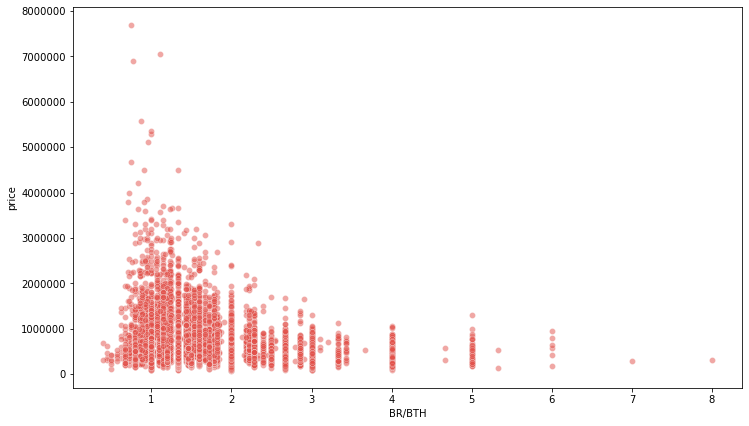

In [218]:
fig,ax = plt.subplots(figsize=(12,7))
sns.scatterplot(x = 'BR/BTH', y = 'price', data = df_ls,alpha=0.5)
ax.ticklabel_format(style='plain');

In [219]:
df_ls.floors.value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

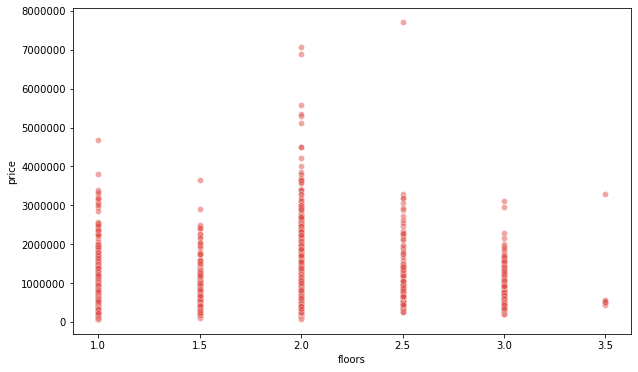

In [220]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'floors', y = 'price', data = df_ls,alpha=0.5)
ax.ticklabel_format(style='plain');

Create new columns by combining

In [227]:
# FAR: Floor Area Ratio
df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']

<ipython-input-227-321bbf913690>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']


In [228]:
# attempt to calculate the yard
# suppose first floor area = (living-basement) / floors
# yard will be: lot - first floor

df_ls['yard'] = df_ls['sqft_lot'] - ( (df_ls['sqft_living'] - df_ls['sqft_basement']) / df_ls['floors'])

<ipython-input-228-72489942dba2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['yard'] = df_ls['sqft_lot'] - ( (df_ls['sqft_living'] - df_ls['sqft_basement']) / df_ls['floors'])


In [229]:
df_ls

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,FAR,yard,BR/BTH
0,221900.0,3,1.0,1180,5650,1.0,0,0.2088495575221239,4470.0,3.0
1,538000.0,3,2.25,2570,7242,2.0,400,0.3548743441038387,6157.0,1.3333333333333333
2,180000.0,2,1.0,770,10000,1.0,0,0.077,9230.0,2.0
3,604000.0,4,3.0,1960,5000,1.0,910,0.392,3950.0,1.3333333333333333
4,510000.0,3,2.0,1680,8080,1.0,0,0.2079207920792079,6400.0,1.5
...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.5,1530,1131,3.0,0,1.3527851458885942,621.0,1.2
21593,400000.0,4,2.5,2310,5813,2.0,0,0.39738517116807154,4658.0,1.6
21594,402101.0,2,0.75,1020,1350,2.0,0,0.7555555555555555,840.0,2.6666666666666665
21595,400000.0,3,2.5,1600,2388,2.0,0,0.6700167504187605,1588.0,1.2


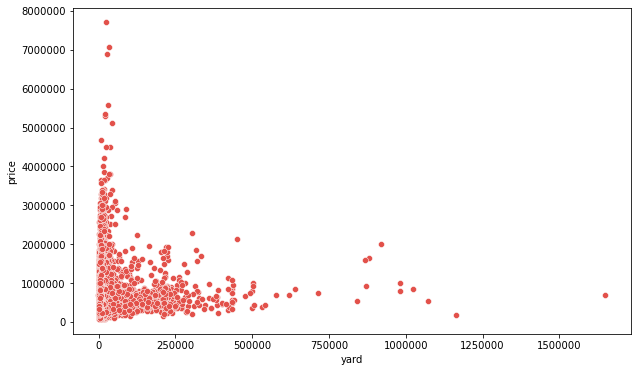

In [230]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x = 'yard', y = 'price', data = df_ls)
ax.ticklabel_format(style='plain');

In [231]:
# Living space / bedrooms
# higher means you have more space for other rooms
# such as kitchen, living room, game room, home gym
df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']

<ipython-input-231-17e96cc7dcf6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']


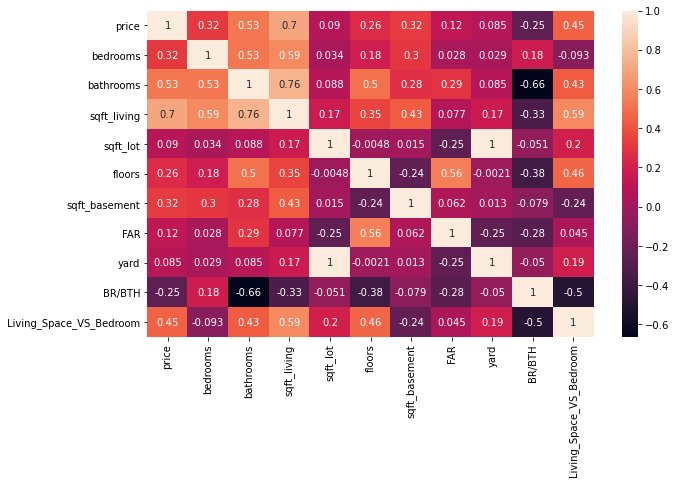

In [232]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_ls.corr(),annot=True);

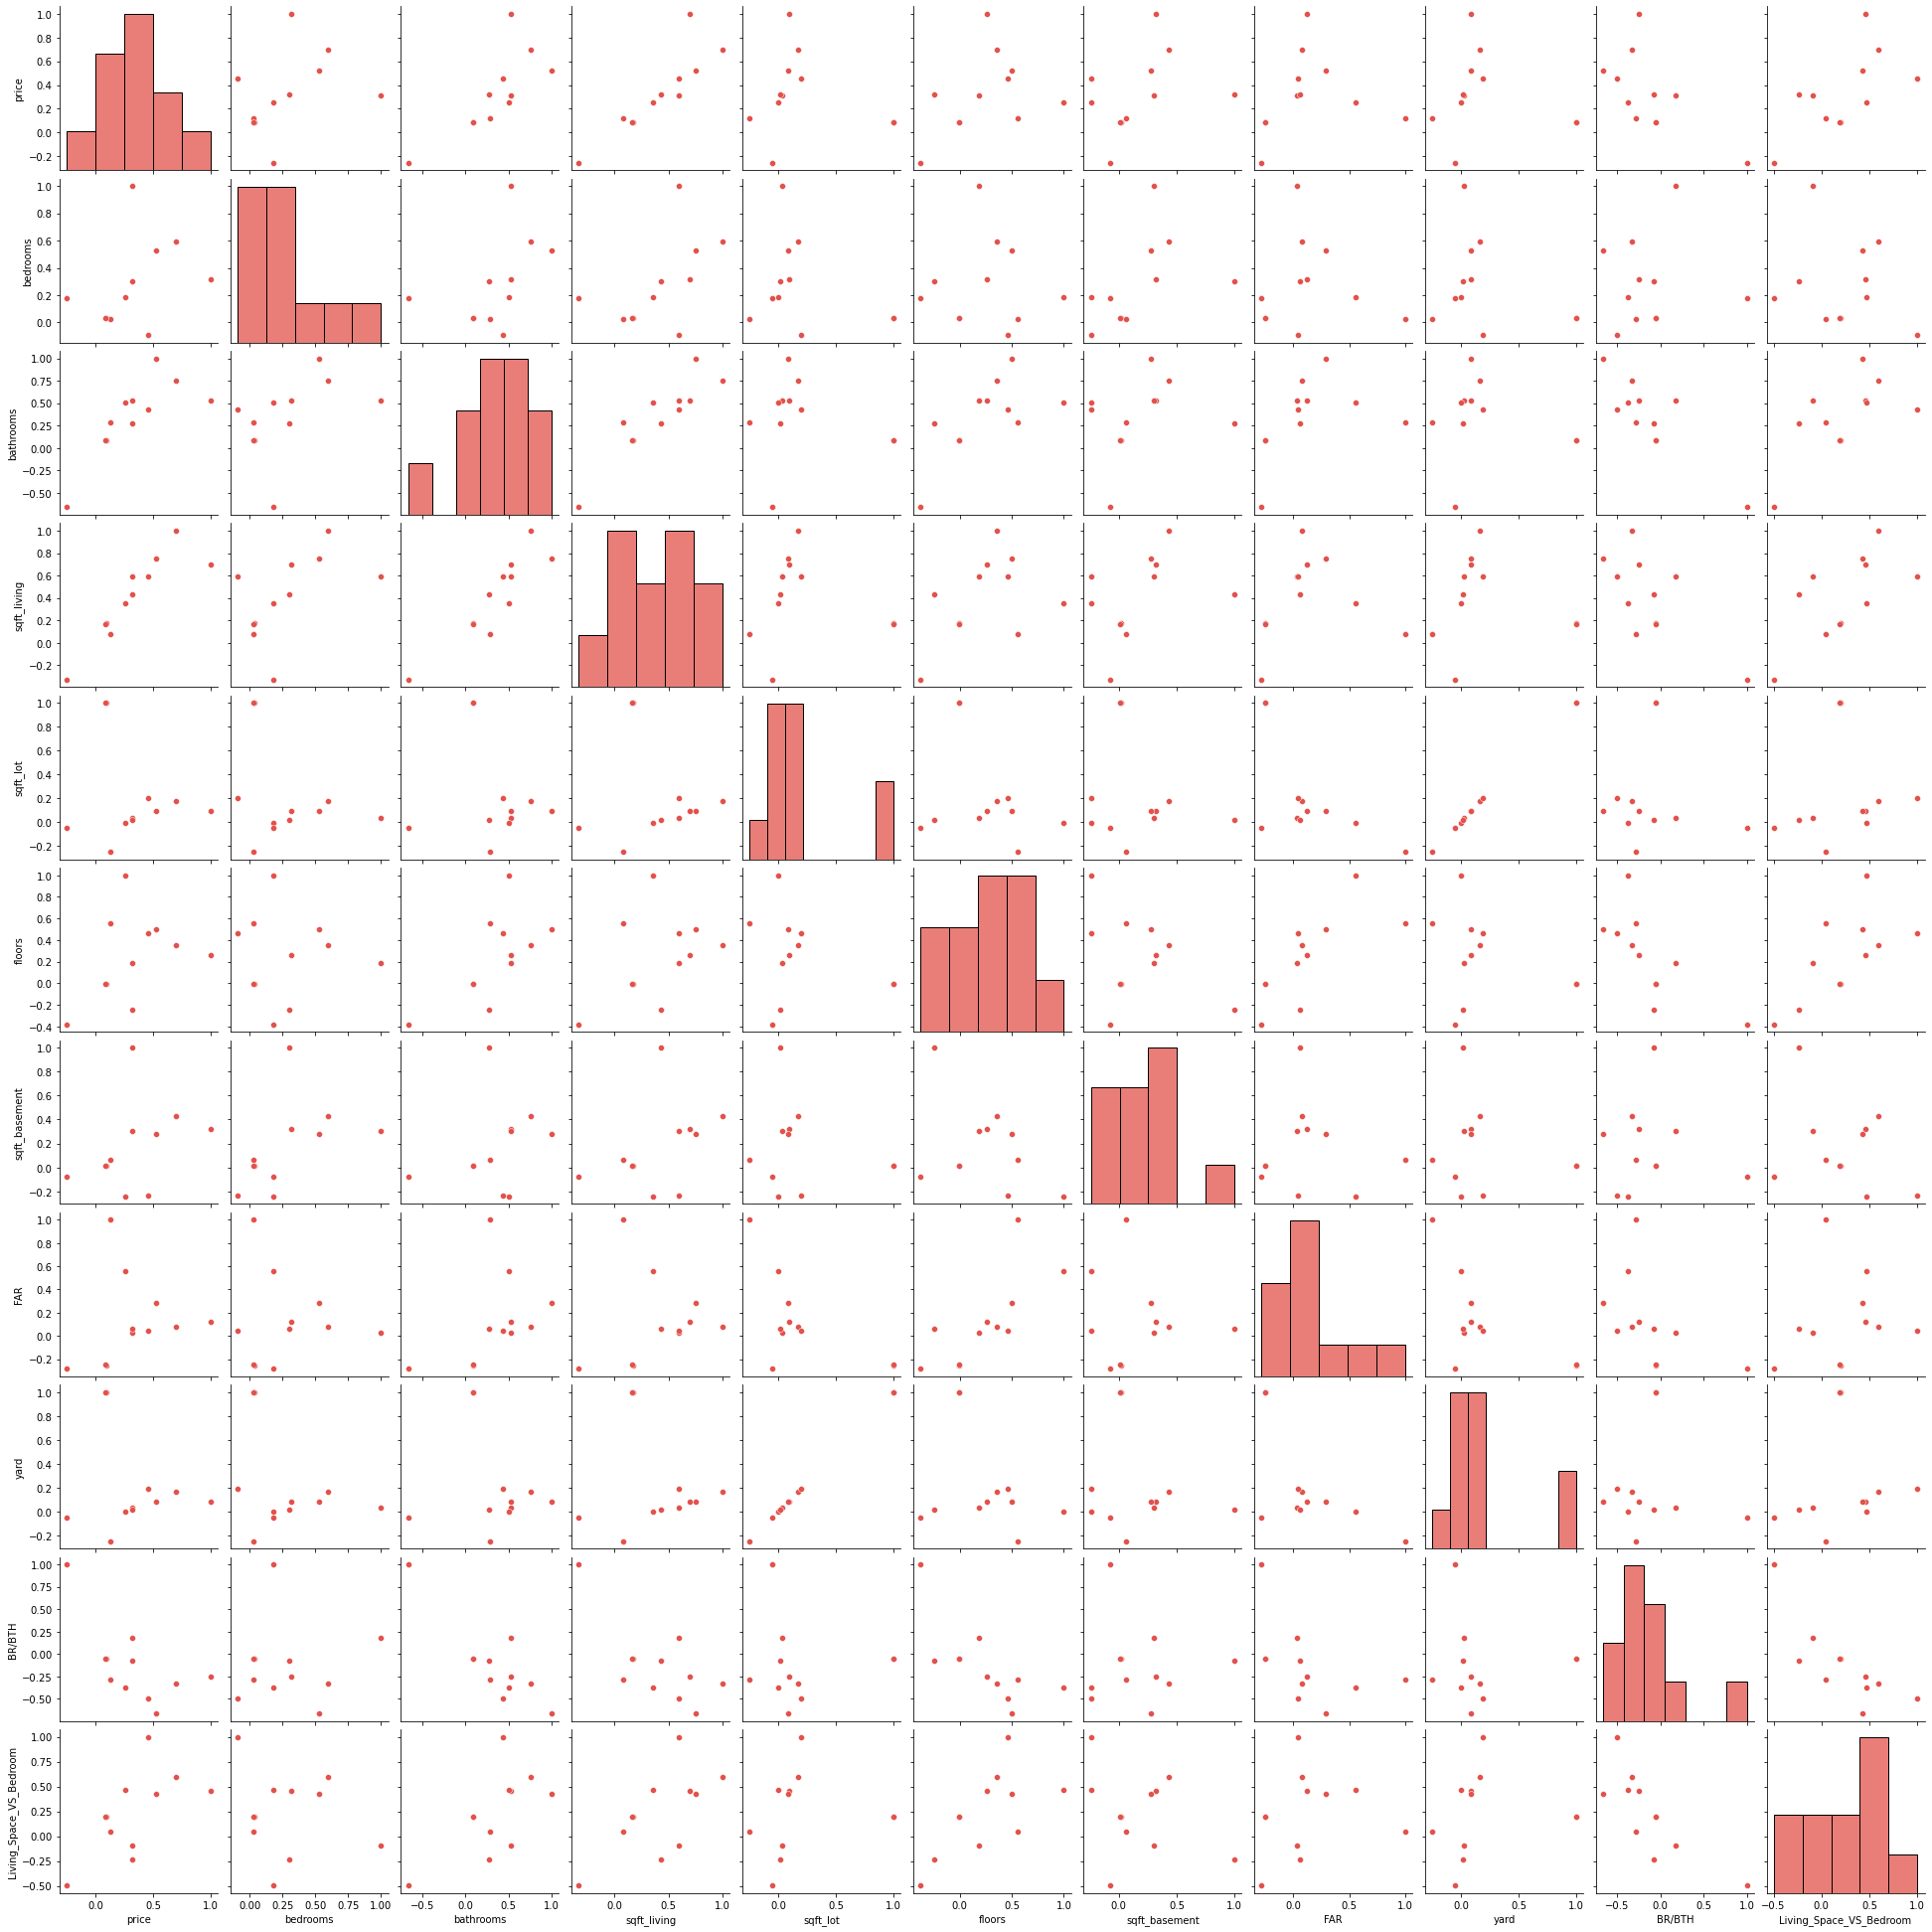

In [236]:
sns.pairplot(df_ls.corr());

## (test only) living space simple baseline model

In [ ]:
col_selector = ['sqft_living','bedrooms','Living_Space_VS_Bedroom','sqft_lot', 'floors']
X_ls = df_ls[col_selector]
y = df_ls.price

In [ ]:
X_ls_stand = X_ls.apply(lambda x: (x-x.mean()/x.std()))
y_stand = (y-y.mean())/y.std()

In [ ]:
ls_simple_model = sm.OLS(y_stand,sm.add_constant(X_ls_stand)).fit()

In [ ]:
print(ls_simple_model.summary())

## EDA HOUSE CONDITION

In [172]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [189]:
col_selector = ['price','grade','condition','yr_built', 'yr_renovated']
df_condition = df[col_selector]
df_condition.head()

,price,grade,condition,yr_built,yr_renovated,view,waterfront
0,221900.0,7,2,1955,0.0,0,0
1,538000.0,7,2,1951,1991.0,0,0
2,180000.0,6,2,1933,0.0,0,0
3,604000.0,7,4,1965,0.0,0,0
4,510000.0,8,2,1987,0.0,0,0


<AxesSubplot:xlabel='condition', ylabel='price'>

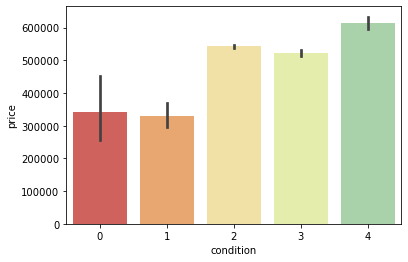

In [174]:
sns.barplot(x = 'condition', y = 'price', data = df_condition)

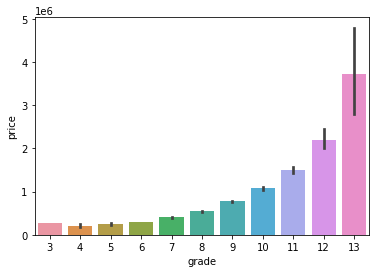

In [176]:
sns.barplot(x = 'grade', y = 'price', data = df_condition);

In [177]:
df_condition.yr_built.value_counts().sort_index()

1900     87
1901     29
1902     27
1903     46
1904     45
       ... 
2011    130
2012    170
2013    201
2014    559
2015     38
Name: yr_built, Length: 116, dtype: int64

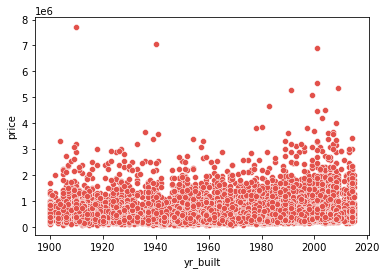

In [178]:
sns.scatterplot(x = 'yr_built', y = 'price', data = df_condition);
# can't tell much

In [190]:
bins = np.arange(1910,2030,10)
labels = np.arange(1,12,1)
df_condition['yr_built_pd'] = pd.cut(df_condition.yr_built, bins = bins, labels = labels,
       include_lowest=True)

<ipython-input-190-4e33cfca62b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['yr_built_pd'] = pd.cut(df_condition.yr_built, bins = bins, labels = labels,


<AxesSubplot:xlabel='yr_built_pd', ylabel='price'>

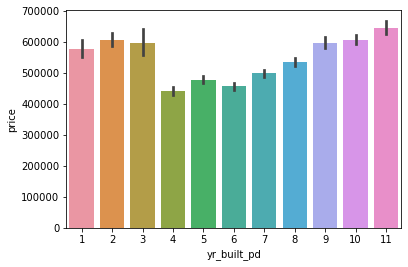

In [192]:
sns.barplot(x = 'yr_built_pd', y = 'price', data = df_condition)
# older house are more expensive
# maybe old house + renovated more expensive?

In [193]:
df_condition['renovated']= df_condition['yr_renovated'].apply(lambda x: 0 if x == 0.0 else 1)
# 1 means renovated, 0 means no
# assume renovated year doesn't matter

<ipython-input-193-8d08a4d84c18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condition['renovated']= df_condition['yr_renovated'].apply(lambda x: 0 if x == 0.0 else 1)


In [194]:
df_condition.renovated

0        0
1        1
2        0
3        0
4        0
        ..
21592    0
21593    0
21594    0
21595    0
21596    0
Name: renovated, Length: 21597, dtype: int64

<AxesSubplot:xlabel='renovated', ylabel='price'>

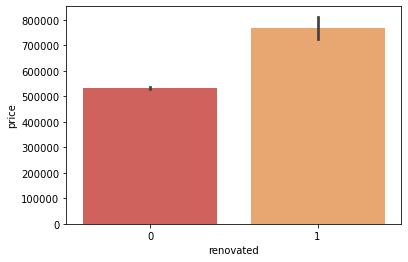

In [196]:
sns.barplot(x = 'renovated', y = 'price', data = df_condition)

<AxesSubplot:>

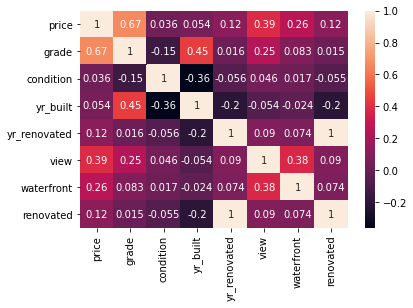

In [197]:
sns.heatmap(df_condition.corr(),annot=True)

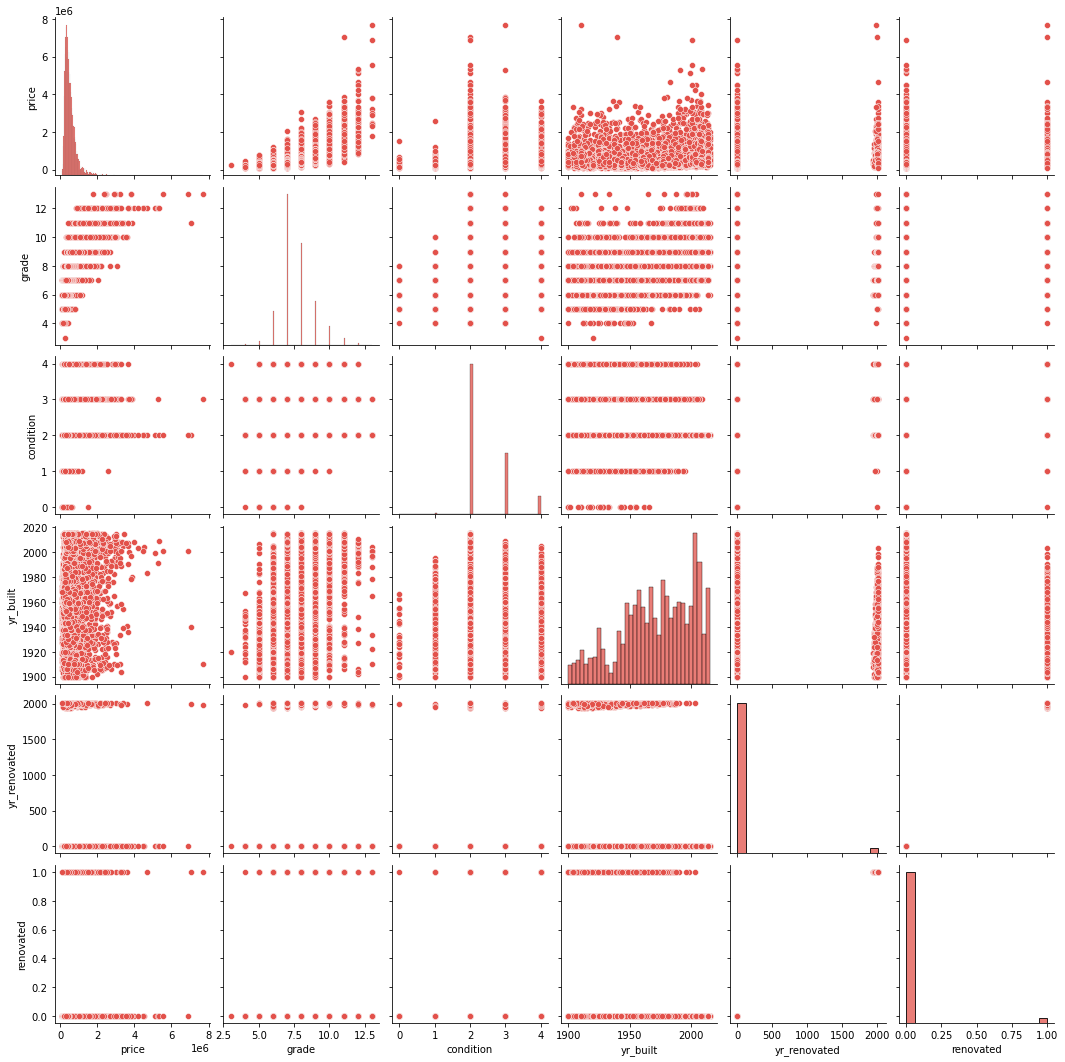

In [187]:
sns.pairplot(df_condition)

# EDA NEIGHBORHOOD

In [ ]:
col_selector = ['price','view','waterfront']
df_loc = df[col_selector]

In [ ]:
df_loc.head()

tips from other sources


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

https://towardsdatascience.com/predicting-house-prices-with-linear-regression-machine-learning-from-scratch-part-ii-47a0238aeac1

https://www.bryanshalloway.com/2020/08/17/pricing-insights-from-historical-data-part-1/